### Import dataset 

In [5]:
import pandas as pd
import numpy as np
import time

train_df_small = pd.read_csv('./final_project_movielens/train_df_small.csv')
val_df_small = pd.read_csv('./final_project_movielens/val_df_small.csv')
test_df_small = pd.read_csv('./final_project_movielens/test_df_small.csv')

In [6]:
train_df_large = pd.read_csv('./final_project_movielens/train_df_large.csv')
val_df_large = pd.read_csv('./final_project_movielens/val_df_large.csv')
test_df_large = pd.read_csv('./final_project_movielens/test_df_large.csv')

### Load lenskit

In [7]:
# pip install lenskit

In [8]:
# from lenskit.datasets import ML100K
from lenskit import batch, topn, util
from lenskit import crossfold as xf
from lenskit.algorithms import Recommender, als, item_knn as knn
from lenskit import topn

### Small dataset

In [9]:
train_df_small.columns = ['user', 'item', 'rating', 'timestamp']
val_df_small.columns = ['user', 'item', 'rating', 'timestamp']
test_df_small.columns = ['user', 'item', 'rating', 'timestamp']

### -train function with hyper parameter tuning

In [40]:
# training function 
def eval(aname, algo, train, test):
    fittable = util.clone(algo)
    fittable = Recommender.adapt(fittable)
    
    # measure training time (fit)
    start_time = time.time()
    fittable.fit(train)
    end_time = time.time()
    print("Total execution time: {} seconds".format(end_time - start_time))
    
    users = test.user.unique()
    # now we run the recommender
    recs = batch.recommend(fittable, users, 100)
    # add the algorithm name for analyzability
    recs['Algorithm'] = aname
    return recs

In [20]:
# checking training data size - training time
test_size = [0.1, 0.2, 0.3 ,0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]
res_time = []

for i in test_size:
    algo_als = als.BiasedMF(features=100, reg=0.0001, iterations=15)
    train_size = int(len(train_df_small) * i)
    print('test_size: ', train_size)
    res_size.append(train_size)
    
    fittable = util.clone(algo_als)
    fittable = Recommender.adapt(fittable)    
    start_time = time.time()
    fittable.fit(train_df_small[:train_size])
    end_time = time.time()
    train_time = end_time - start_time
    print("Total execution time: {} seconds".format(train_time))
    res_time.append(train_time)

test_size:  8553
Total execution time: 0.19010472297668457 seconds
test_size:  17106
Total execution time: 0.23639893531799316 seconds
test_size:  25659
Total execution time: 0.30144309997558594 seconds
test_size:  34212
Total execution time: 0.3651740550994873 seconds
test_size:  42765
Total execution time: 0.4164409637451172 seconds
test_size:  51318
Total execution time: 0.46843409538269043 seconds
test_size:  59870
Total execution time: 0.549260139465332 seconds
test_size:  68424
Total execution time: 0.6039140224456787 seconds
test_size:  76977
Total execution time: 0.6754753589630127 seconds
test_size:  85530
Total execution time: 0.7380328178405762 seconds


In [41]:
# adding result for spark als training data size / training time
spark_time = [16.433910131454468, 20.001993656158447, 24.58430767059326, 28.43294906616211, 32.00606560707092,
              35.43891978263855, 39.58369994163513, 41.847962617874146, 41.75053405761719, 32.59766674041748]

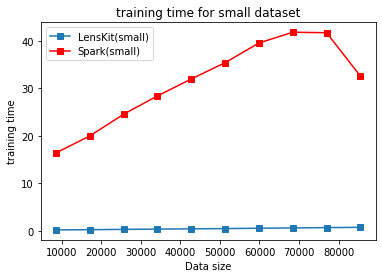

In [45]:
# plotting the result
import matplotlib.pyplot as plt

plt.title('training time for small dataset')
plt.plot(res_size, res_time, marker = 's', label = 'LensKit(small)')
plt.plot(res_size, spark_time, marker = 's', color = 'r', label = 'Spark(small)')
plt.xlabel('Data size')
plt.ylabel('training time')
plt.legend()
plt.show()

In [15]:
import itertools as it

rank = [100]
regParam = [0.0001]
maxIter = [5, 10, 15]
params = it.product(rank, regParam, maxIter)

for rank, regParam, maxIter in params:
    algo_als = als.BiasedMF(features=rank, reg=regParam, iterations=maxIter)
    print('Hyperparameters) rank: ', rank, 'regParam: ', regParam, 'maxIter: ', maxIter)
    
    all_recs = eval('ALS', algo_als, train_df_small, val_df_small)
    rla = topn.RecListAnalysis()
    rla.add_metric(topn.ndcg)
    results = rla.compute(all_recs, val_df_small)
    als_result = results.groupby('Algorithm').ndcg.mean()
    print('val_score: ', als_result[0])
    
    all_recs = eval('ALS', algo_als, train_df_small, test_df_small)
    rla = topn.RecListAnalysis()
    rla.add_metric(topn.ndcg)
    results = rla.compute(all_recs, test_df_small)
    als_result = results.groupby('Algorithm').ndcg.mean()
    print('test_score: ', als_result[0])
    print()

Hyperparameters) rank:  100 regParam:  0.0001 maxIter:  5
Total execution time: 0.3176712989807129 seconds
val_score:  0.05961486687567417

Total execution time: 0.2900516986846924 seconds
test_score:  0.07532731308048904

Hyperparameters) rank:  100 regParam:  0.0001 maxIter:  10
Total execution time: 0.4993300437927246 seconds
val_score:  0.05812086251801631

Total execution time: 0.5022611618041992 seconds
test_score:  0.07370470214220019

Hyperparameters) rank:  100 regParam:  0.0001 maxIter:  15
Total execution time: 0.7007009983062744 seconds
val_score:  0.05681039415023906

Total execution time: 0.7035200595855713 seconds
test_score:  0.07508359358948152



# ----------------------------------------------------

### large dataset

In [9]:
train_df_large.columns = ['user', 'item', 'rating', 'timestamp']
val_df_large.columns = ['user', 'item', 'rating', 'timestamp']
test_df_large.columns = ['user', 'item', 'rating', 'timestamp']

### -train function with hyper parameter tuning

In [10]:
# training function 
def eval(aname, algo, train, test):
    fittable = util.clone(algo)
    fittable = Recommender.adapt(fittable)
    
    # measure training time (fit)
    start_time = time.time()
    fittable.fit(train)
    end_time = time.time()
    print("Total execution time: {} seconds".format(end_time - start_time))
    
    users = test.user.unique()
    # now we run the recommender
    recs = batch.recommend(fittable, users, 100)
    # add the algorithm name for analyzability
    recs['Algorithm'] = aname
    return recs

In [11]:
# checking training data size - training time
test_size = [0.1, 0.2, 0.3 ,0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]
res_time_l = []

for i in test_size:
    algo_als = als.BiasedMF(features=300, reg=0.01, iterations=15)
    train_size = int(len(train_df_large) * i)
    print('test_size: ', train_size)
    res_size_l.append(train_size)
    
    fittable = util.clone(algo_als)
    fittable = Recommender.adapt(fittable)    
    start_time = time.time()
    fittable.fit(train_df_large[:train_size])
    end_time = time.time()
    train_time = end_time - start_time
    print("Total execution time: {} seconds".format(train_time))
    res_time_l.append(train_time)

test_size:  2335238


BLAS using multiple threads - can cause oversubscription
found 1 potential runtime problems - see https://boi.st/lkpy-perf


Total execution time: 40.68474531173706 seconds
test_size:  4670477
Total execution time: 86.83887910842896 seconds
test_size:  7005715
Total execution time: 143.78360390663147 seconds
test_size:  9340954
Total execution time: 212.28115892410278 seconds
test_size:  11676193
Total execution time: 280.508581161499 seconds
test_size:  14011431
Total execution time: 352.19370126724243 seconds
test_size:  16346670
Total execution time: 429.5296959877014 seconds
test_size:  18681908
Total execution time: 519.1176099777222 seconds
test_size:  21017147
Total execution time: 598.2305738925934 seconds
test_size:  23352386
Total execution time: 679.0631191730499 seconds


In [12]:
# adding result for spark als training data size / training time
spark_time_l = [889.8123462200165, 1426.1737356185913, 1940.3998234272003, 2402.7107257843018, 2726.5582246780396,
                3473.0376164913177, 3915.3467049598694, 4370.167536735535, 4823.548748731613, 5380.3844339847565]

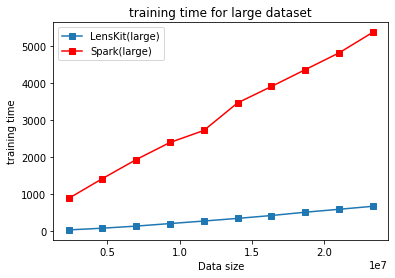

In [13]:
# plotting the result
import matplotlib.pyplot as plt

plt.title('training time for large dataset')
plt.plot(res_size_l, res_time_l, marker = 's', label = 'LensKit(large)')
plt.plot(res_size_l, spark_time_l, marker = 's', color = 'r', label = 'Spark(large)')
plt.xlabel('Data size')
plt.ylabel('training time')
plt.legend()
plt.show()

In [35]:
import itertools as it

rank = [300]
regParam = [0.005]
maxIter = [5, 10, 15]
params = it.product(rank, regParam, maxIter)

for rank, regParam, maxIter in params:
    algo_als = als.BiasedMF(features=rank, reg=regParam, iterations=maxIter)
    print('Hyperparameters) rank: ', rank, 'regParam: ', regParam, 'maxIter: ', maxIter)
    
    all_recs = eval('ALS', algo_als, train_df_large, val_df_large)
    rla = topn.RecListAnalysis()
    rla.add_metric(topn.ndcg)
    results = rla.compute(all_recs, val_df_large)
    als_result = results.groupby('Algorithm').ndcg.mean()
    print('val_score: ', als_result[0])
    
    all_recs = eval('ALS', algo_als, train_df_large, test_df_large)
    rla = topn.RecListAnalysis()
    rla.add_metric(topn.ndcg)
    results = rla.compute(all_recs, test_df_large)
    als_result = results.groupby('Algorithm').ndcg.mean()
    print('test_score: ', als_result[0])
    print()

Hyperparameters) rank:  300 regParam:  0.005 maxIter:  5
Total execution time: 246.8783152103424 seconds
val_score:  0.02837698192865911
Total execution time: 258.78653264045715 seconds
test_score:  0.028403027472402465

Hyperparameters) rank:  300 regParam:  0.005 maxIter:  10
Total execution time: 600.5703210830688 seconds
val_score:  0.025962549816462434
Total execution time: 500.07431292533875 seconds
test_score:  0.02594980106913568

Hyperparameters) rank:  300 regParam:  0.005 maxIter:  15
Total execution time: 770.1668217182159 seconds
val_score:  0.025350117607059436
Total execution time: 701.3095932006836 seconds
test_score:  0.02540554399838886



In [36]:
import itertools as it

rank = [300]
regParam = [0.01]
maxIter = [5, 10, 15]
params = it.product(rank, regParam, maxIter)

for rank, regParam, maxIter in params:
    algo_als = als.BiasedMF(features=rank, reg=regParam, iterations=maxIter)
    print('Hyperparameters) rank: ', rank, 'regParam: ', regParam, 'maxIter: ', maxIter)
    
    all_recs = eval('ALS', algo_als, train_df_large, val_df_large)
    rla = topn.RecListAnalysis()
    rla.add_metric(topn.ndcg)
    results = rla.compute(all_recs, val_df_large)
    als_result = results.groupby('Algorithm').ndcg.mean()
    print('val_score: ', als_result[0])
    
    all_recs = eval('ALS', algo_als, train_df_large, test_df_large)
    rla = topn.RecListAnalysis()
    rla.add_metric(topn.ndcg)
    results = rla.compute(all_recs, test_df_large)
    als_result = results.groupby('Algorithm').ndcg.mean()
    print('test_score: ', als_result[0])
    print()

Hyperparameters) rank:  300 regParam:  0.01 maxIter:  5
Total execution time: 241.3149130344391 seconds
val_score:  0.028336329662717596
Total execution time: 251.8516697883606 seconds
test_score:  0.028584531743021863

Hyperparameters) rank:  300 regParam:  0.01 maxIter:  10
Total execution time: 475.1515848636627 seconds
val_score:  0.02590920827237602
Total execution time: 457.14285492897034 seconds
test_score:  0.025973842678105548

Hyperparameters) rank:  300 regParam:  0.01 maxIter:  15
Total execution time: 676.6912682056427 seconds
val_score:  0.02544386216893131
Total execution time: 676.7379970550537 seconds
test_score:  0.025418904175635783

